In [30]:
from scipy.signal import butter, filtfilt, find_peaks, freqz, sosfilt
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib widget
import numpy as np 
import pandas as pd 
import gc
import cupy as cp
import multiprocessing as mp
from multiprocessing import shared_memory, Process, Lock, Pool
from multiprocessing import cpu_count, current_process
import ray
import itertools

sys.path.insert(0, '../../drlib')
import drlib as dr

madCor = 1.4826

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2Freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]


In [31]:
#Ben's code to convert config file to parsedList and configDic

from collections import namedtuple
from datetime import datetime
from multiprocessing import Pool
import bisect
import configparser
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt 
import h5py as h5
import os
import pandas as pd
import sys

"""
Convert the float parameters in the config file to floats
Parameters:
   aString: The string in the config file
Returns:
    holder (1D list): List of floats
"""
def getFloatBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [float(x) for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Convert the date parameters in the config file to floats
Parameters:
   aString: The date string in the config file
Returns:
    holder (1D list): List of datetime objects written as month/day/year hour:minute:second.microseconds
"""
def getDateBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [datetime.strptime(x.strip(), '%m/%d/%Y %H:%M:%S.%f')  for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Take in a config file and return a dictionary of bounds
Parameters:
   configFile: The config file
   configName: The name of the configuration setup
Returns:
    configDict (dictionary): Dictionary of bounds
"""
def getAllBounds(configFile, configName):
    configSetup = configparser.ConfigParser()
    configSetup.read(configFile)
    configDict = {}
    tempBounds = getFloatBounds(configSetup[configName]['Temperature'])
    freqBounds = getFloatBounds(configSetup[configName]['Frequency'])
    dateBounds = getDateBounds(configSetup[configName]['Date'])
    antWestBounds =  getFloatBounds(configSetup[configName]['AntennaWest'])
    antVertBounds = getFloatBounds(configSetup[configName]['AntennaVert'])
    antSouthBounds = getFloatBounds(configSetup[configName]['AntennaSouth'])
    antThetaBounds = getFloatBounds(configSetup[configName]['AntennaTheta'])
    antPhiBounds = getFloatBounds(configSetup[configName]['AntennaPhi'])
    measChoice = configSetup['TEST']['Measurement']
    configDict['Temp'] = tempBounds 
    configDict['Freq'] = freqBounds
    configDict['Date'] = dateBounds
    configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
    configDict['Choice'] = measChoice
    return configDict

"""
Return the indices in the "database" that fall within the specified
bound. This function assumes that the database is ordered by the 
parameter being searched for.
Parameters:
   val: The value in the config file
   parsedList: List of the parameter being searched for (e.g. date/temperature/antenna position)
Returns:
    holderIndices: List of all the indices in the sorted list that fall in the bounds
"""
def parseOnce(val, parsedList):
    #print('VAL: ' + str(val))
    if len(parsedList) == 0:
        return []
    
    holderIndices = []
    if val[0] > val[1]:
        print('CONFUSED ORDERING')
        return []
    if val[0] == -1:
        startIndex = 0
    elif val[0] < parsedList[0]:
        startIndex = 0
    elif val[0] > parsedList[-1]:
        print('EMPTY LIST')
        return []
    else:
        startIndex = bisect.bisect_left(parsedList, val[0])
    if val[1] == -1:
        endIndex = len(parsedList)
    elif val[1] > parsedList[-1]:
        endIndex = len(parsedList)
    else:
        endIndex = bisect.bisect_right(parsedList, val[1])
    
    [holderIndices.append(x) for x in range(startIndex, endIndex)]    
    return holderIndices

"""
Obtain all the datasets that fall within the bounds given in the config
file.
Parameters:
   configFile: The name of the configuration file
   configName: The name of the configuration setup in the config file 
Returns:
    parsedList: List of all the parsed data files defined as a list of tuples
                of the form ((file number, save number), date, temperature, antenna position).)
                    - Date is a datetime object
                    - Antenna position is a tuple of the form (west, vertical, south, theta, phi)

"""
def getParsedList(configFile, configName):
    #dbFile = '/group/tysongrp/SearchableDatabase.txt'
    dbFile = './SearchableDatabase.txt'

    allData = []
    configDict = getAllBounds(configFile, configName)
    #print('BOUNDS: ' + str(configDict))
    with open(dbFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split()
            holder = [x.replace(',', '') if counter > 0 else x for counter, x in enumerate(holder)]
            try:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S.%f')
            except:
                 dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S')

            tempVal = float(holder[3])
            antPos = (float(holder[4][1:]), float(holder[5]), float(holder[6]), float(holder[7]), float(holder[8][:-1]))
            fileNum = float(holder[0][1:holder[0].index(',')])
            runNum = float(holder[0][holder[0].index(',')+1:-2])
            allData.append(((fileNum, runNum), dateVal, tempVal, antPos))
    
    holderIndices = []
    allData = sorted(allData, key = lambda x: x[1])
    parsedList = allData
    for val in np.reshape(configDict['Date'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[1] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]
    

# configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
# allData.append(((fileNum, runNum), dateVal, tempVal, antPos, antPos))

    for antSortVal in range(len(configDict['Ant'])):
        parsedList = sorted(parsedList, key = lambda x: x[3][antSortVal])
        holderIndices = []
        for val in np.reshape(configDict['Ant'][antSortVal], (-1, 2)):
            [holderIndices.append(x) for x in parseOnce(val, [x[3][0] for x in parsedList])]

        holderIndices = np.asarray([*set(holderIndices)])
        parsedList = [parsedList[x] for x in holderIndices]

    parsedList = sorted(parsedList, key = lambda x: x[2])
    holderIndices = []
    for val in np.reshape(configDict['Temp'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[2] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]  
    
    parsedList = sorted(parsedList, key=lambda x: (x[0][0], x[0][1]))
    return parsedList, configDict
    #[print(x) for x in parsedList]


In [32]:
freqsAll    = np.load('./run1_freqData_avgAll11776Spectra_gitignore.npy')
antDataAll  = np.load('./run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termDataAll = np.load('./run1_termData_avgAll11776Spectra_gitignore.npy')[1:]

freqStart   = 50 #MHz
freqStop    = 300 #MHz


idxStart    = freq2Idx(freqStart, freqsAll)
idxStop     = freq2Idx(freqStop, freqsAll)
print('Starting frequency = ', freqStart, 'MHz')
print('Stop frequency = ', freqStop, 'MHz')
print('Starting index = ', idxStart)
print('Stop index = ', idxStop)


#default arrays are in watts and trimmed
freqs       = freqsAll[idxStart:idxStop]
antSpec     = dr.fft2Watts(antDataAll)[idxStart:idxStop]
termSpec    = dr.fft2Watts(termDataAll)[idxStart:idxStop]

diffSpec    = antSpec - termSpec
ratioSpec   = antSpec / termSpec

Starting frequency =  50 MHz
Stop frequency =  300 MHz
Starting index =  1398101
Stop index =  8388607


5.6603108175258616e-12
17 candidates (dumb limit)


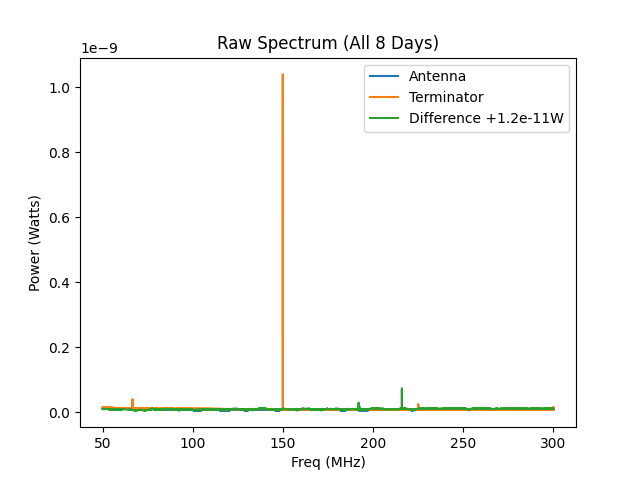

In [64]:
#plot raw averaged spectrum (all data)

dumbLimit = (antSpec.std()*5) + antSpec.mean()
print((antSpec.std()*5))
print((antSpec > dumbLimit).sum(), "candidates (dumb limit)")

#plt.close('all')
plt.figure()
plt.title('Raw Spectrum (All 8 Days)')
plt.plot(freqs, antSpec, label = 'Antenna')
plt.plot(freqs, termSpec, label = 'Terminator')
plt.plot(freqs, diffSpec+1.2e-11, label = 'Difference +1.2e-11W')
#plt.plot(freqs, ratioSpec*1e-11, label = 'Ratio*1e-11')
#plt.plot((freqStart, 300),(dumbLimit,dumbLimit), label = 'mean+5*STD(ant)')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

Antenna limit (std) = 1.9466988153568923e-12 Watts
filtered raw antenna data has  18 candidates (std)
Antenna limit (mad) = 1.2782357190307719e-14 Watts
filtered raw antenna data has  1632 candidates (mad)

Terminator limit (std) = 1.941318760720129e-12 Watts
filtered raw terminator data has  12 candidates (std)
Terminator limit (mad) = 1.4747077083314733e-14 Watts
filtered raw terminator data has  329 candidates (mad)

diff limit (std) = 1.3100384907578566e-13 Watts
filtered raw diff data has  78 candidates (std)
diff limit (mad) = 1.9581617395129566e-14 Watts
filtered raw diff data has  876 candidates (mad)

term spec filtered median =  -4.137336318010783e-18


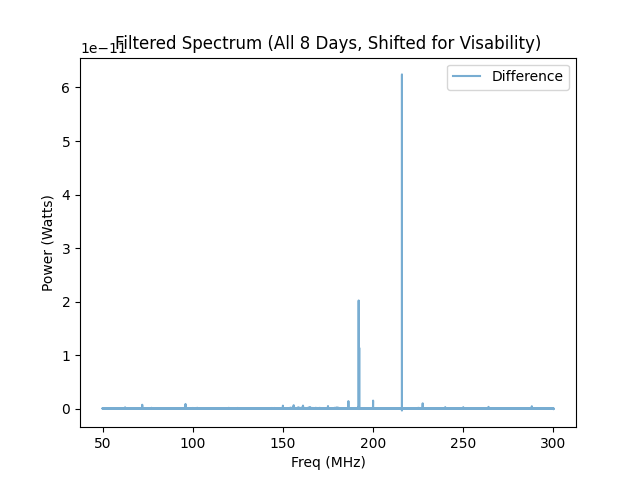

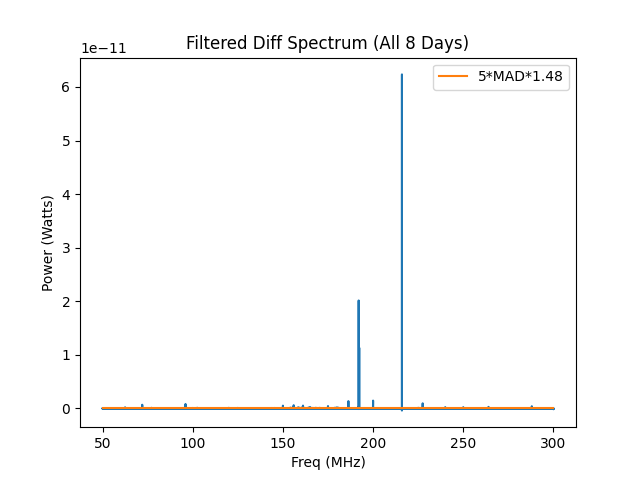

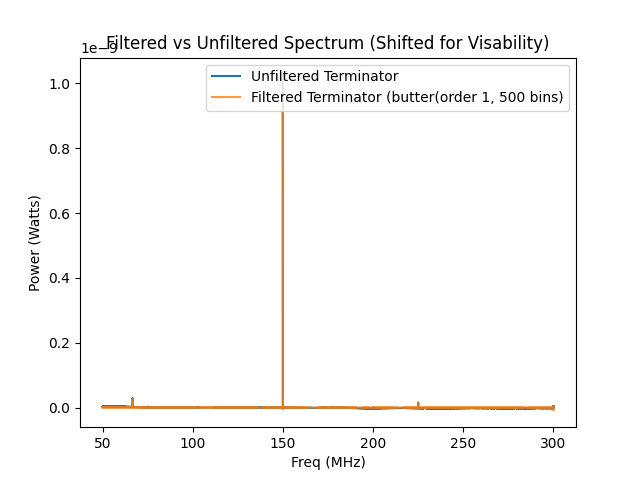

In [80]:
#filter and plot with 5sigma limit. Note these are not gain corrected!!!

nSigma = 5
order = 1
fc_numBins = 500

#antSpecFiltered = dr.gausHpf(antSpec, sigma = sigma)
antSpecFiltered = dr.filterSpec(antSpec, fc_numBins=fc_numBins, order=order)
antMad = sp.stats.median_abs_deviation(antSpecFiltered)
antStd = np.std(antSpecFiltered)
antLimitMad = nSigma * antMad * madCor
antLimitStd = nSigma * antStd

#termSpecFiltered = dr.gausHpf(termSpec, sigma = sigma)
termSpecFiltered = dr.filterSpec(termSpec, fc_numBins=fc_numBins, order=order)
termMad = sp.stats.median_abs_deviation(termSpecFiltered)
termStd = np.std(termSpecFiltered)
termLimitMad = nSigma * termMad * madCor
termLimitStd = nSigma * termStd

#diffSpecFiltered = dr.gausHpf(diffSpec, sigma = sigma)
diffSpecFiltered = dr.filterSpec(diffSpec, fc_numBins=fc_numBins,order=order)
diffMad = sp.stats.median_abs_deviation(diffSpecFiltered)
diffStd = np.std(diffSpecFiltered)
diffLimitMad = nSigma * diffMad * madCor
diffLimitStd = nSigma * diffStd



nCandidatesAntStd = (antSpecFiltered > antLimitStd).sum()
print('Antenna limit (std) =', antLimitStd, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntStd, 'candidates (std)')
nCandidatesAntMad = (antSpecFiltered > antLimitMad).sum()
print('Antenna limit (mad) =', antLimitMad, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntMad, 'candidates (mad)')
print()
nCandidatesTermStd = (termSpecFiltered > termLimitStd).sum()
print('Terminator limit (std) =', termLimitStd, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermStd, 'candidates (std)')
nCandidatesTermMad = (termSpecFiltered > termLimitMad).sum()
print('Terminator limit (mad) =', termLimitMad, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermMad, 'candidates (mad)')
print()
nCandidatesDiffStd = (diffSpecFiltered > diffLimitStd).sum()
print('diff limit (std) =', diffLimitStd, 'Watts')
print('filtered raw diff data has ', nCandidatesDiffStd, 'candidates (std)')
nCandidatesDiffMad = (diffSpecFiltered > diffLimitMad).sum()
print('diff limit (mad) =', diffLimitMad, 'Watts')
print('filtered raw diff data has ', nCandidatesDiffMad, 'candidates (mad)')
print()

plt.close('all')
plt.figure()
plt.title('Filtered Spectrum (All 8 Days, Shifted for Visability)')
#plt.plot(freqs, antSpecFiltered, label = 'Antenna')
#plt.plot(freqs, termSpecFiltered+.5e-13, label = 'Terminator', alpha = .6)
plt.plot(freqs, diffSpecFiltered+1e-13, label = 'Difference', alpha = .6)
#plt.plot(freqs, ratioSpecFiltered*1e-11+1.5e-13, label = 'Ratio*1e-11', alpha = .6)
#plt.plot((freqStart, 300),(dumbLimit,dumbLimit), label = 'mean+5*STD(ant)')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

plt.figure()
plt.title('Filtered Diff Spectrum (All 8 Days)')
plt.plot(freqs, diffSpecFiltered)
plt.plot((freqStart, freqStop),(diffLimitMad,diffLimitMad), label = '5*MAD*1.48')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

#plt.close('all')
plt.figure()
plt.title('Filtered vs Unfiltered Spectrum (Shifted for Visability)')
plt.plot(freqs, termSpec-1.1e-11, label = 'Unfiltered Terminator')
#plt.plot(freqs, diffSpecFiltered+1.1e-11, label = 'Filtered Difference', alpha = .8)
plt.plot(freqs, termSpecFiltered, label = 'Filtered Terminator (butter(order 1, 500 bins)', alpha = .8)
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

print('term spec filtered median = ', np.median(termSpecFiltered))


mean  =  -0.00044762824386703246
mad * 1.48 =  2.1354140427808845
std =  2.887639358224937


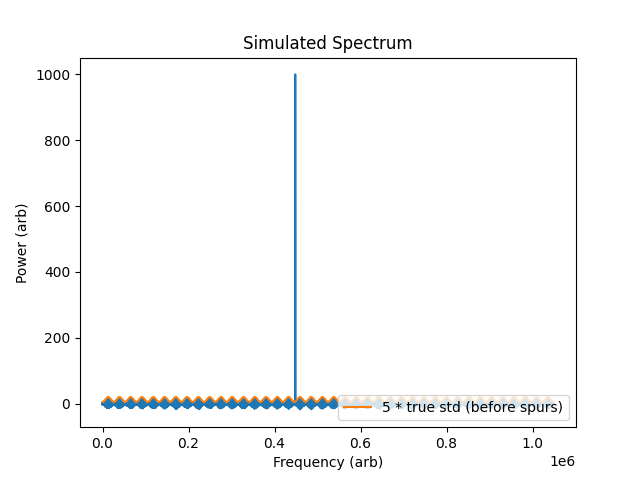

In [81]:
#generate test data (x)

#generate spectrum with known STD (sin^2)
testLength      = 2**20
numStdPoints    = 2**10
stds            = 3*np.sin(np.linspace(0, 40*3.14, numStdPoints))**2 + 1
stdsInterp      = 3*np.sin(np.linspace(0, 40*3.14, testLength))**2 + 1
x               = np.random.normal(0, stds,  size=(testLength//numStdPoints, numStdPoints)) 
x               = np.reshape(x.T, testLength)

#Inject spurs
x[int(testLength//2.34)] = 1000

plt.figure()
plt.title("Simulated Spectrum")
plt.plot(x)
plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
plt.xlabel('Frequency (arb)')
plt.ylabel('Power (arb)')
plt.legend(loc = 'lower right')

print('mean  = ', x.mean())
print('mad * 1.48 = ', 1.4826*sp.stats.median_abs_deviation(x))
print('std = ', np.std(x))


In [41]:
window = 1000

diffFiltRollingMadArr = dr.rolling(diffSpecFiltered, window, 1, sp.stats.median_abs_deviation, numProc=48)



done mp


filtered diff data has  787 candidates (rolling mad)
filtered diff data has  1416  points below -5sigma

[False False False ... False False False]


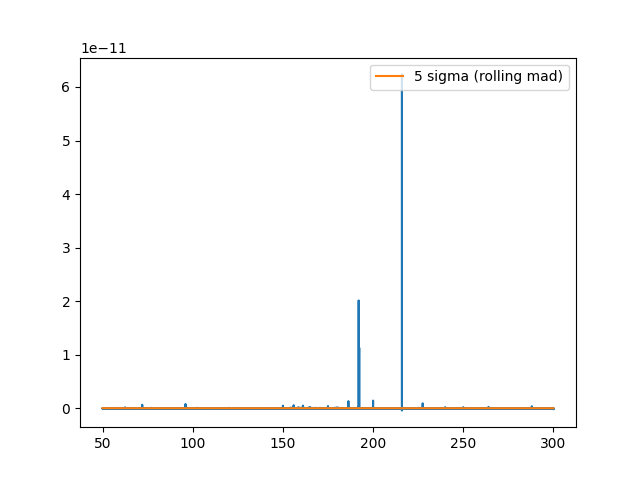

In [82]:
#use negative going candidates to exclude 
filter_fc           = 30 * window
diffFilteredMadArr  = dr.filterSpec(diffFiltRollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
diffFilterMadPadArr = dr.nanPad(diffFilteredMadArr, window)
diffRollMadLim      = diffFilterMadPadArr * 5 * madCor

CandidatesDiffRollMad = (diffSpecFiltered > diffRollMadLim)
print('filtered diff data has ', CandidatesDiffRollMad.sum(), 'candidates (rolling mad)')
negPoints= (diffSpecFiltered < -diffRollMadLim)
print('filtered diff data has ', negPoints.sum(), ' points below -5sigma')
print()

print(np.logical_and(CandidatesDiffRollMad, negPoints))

plt.close('all')

plt.figure()
plt.plot(freqs, diffSpecFiltered)
plt.plot(freqs,diffRollMadLim, label = '5 sigma (rolling mad)')
#plt.plot(freqs,-diffRollMadLim, label = '-5 sigma (rolling mad)')
plt.legend(loc = 'upper right')

In [83]:
candidateIdxs = np.where(CandidatesDiffRollMad)[0]
freqs[candidateIdxs].size
#diffRollMadLim[candidateIdxs].size

#candidateIdxs = candidateIdxs[0:50]

787

"\nplt.figure()\nplt.hist(idxDiff, bins = 10000, range=(2,10002))\nplt.title('Difference Between Adjacent Candidates')\nplt.xlabel('Difference')\nplt.ylabel('Counts')\n\nplt.figure()\nplt.bar(binsNoZeros, histNoZeros)\nplt.title('Difference Between Adjacent Candidates')\nplt.xlabel('Difference')\nplt.ylabel('Counts')\nplt.xticks(rotation='vertical')"

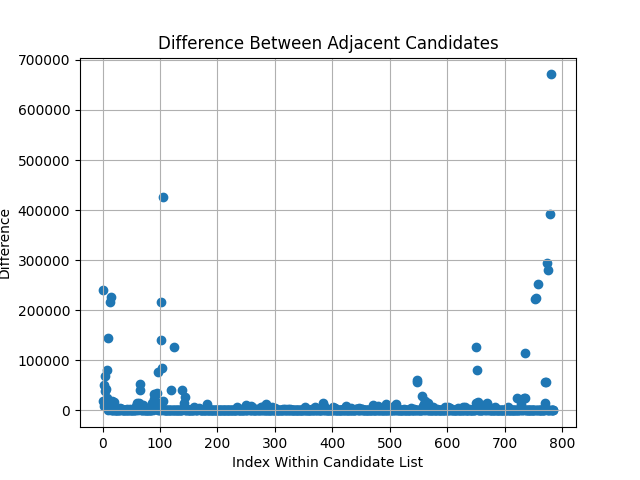

In [84]:
#create a list of bunches of spurs
print()
idxDiff = np.diff(candidateIdxs)
#print(idxDiff)
diffMask = np.where(idxDiff == 1, True, False)
diffMask = np.append(False, diffMask,)

onesIdxs = candidateIdxs[diffMask]
#print(freqs[onesIdxs])

hist, binEdges = np.histogram(idxDiff, bins = 10000, range=(1,10001))
#print(binEdges)
histNoZeros = []
binsNoZeros = []
for i, val in enumerate(hist):
    if val != 0 and val != 1:
        histNoZeros.append(val)
        binsNoZeros.append(binEdges[i])
binsNoZeros =[str(int(bin)) for bin in binsNoZeros]

plt.close('all')
plt.figure()
#plt.semilogy()
plt.scatter(np.arange(0, len(idxDiff), 1),(idxDiff))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Index Within Candidate List')
plt.ylabel('Difference')
plt.grid()

'''
plt.figure()
plt.hist(idxDiff, bins = 10000, range=(2,10002))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Difference')
plt.ylabel('Counts')

plt.figure()
plt.bar(binsNoZeros, histNoZeros)
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Difference')
plt.ylabel('Counts')
plt.xticks(rotation='vertical')'''

In [95]:

def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList]
    canListFreq =  [idx2Freq(can[0],freqs) for can in splitList]
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['can freq'] = canListFreq
    candidate_df['num bins'] = canLenList
    candidate_df['idx'] = canList
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['delta'] = diffArr
    return candidate_df

stepsize = 50
candidate_df = consolidateCandidates(candidateIdxs, freqs, stepsize=stepsize)
#candidate_df.to_csv('candidateListCsvs/candidateList_diffGreaterThan30Bins_rollingMad_antMinusTerm_butterFilt_fc300binsOrder2_11_20_22.csv')
candidate_df

,can freq,num bins,idx,delta
0,51.400364,1,39157,NaN
1,59.989799,1,279335,240178.0
2,60.681809,1,298685,19350.0
3,62.499024,1,349498,50813.0
4,62.789596,1,357623,8125.0
...,...,...,...,...
342,249.996145,2,5592297,279518.0
343,250.000114,2,5592408,111.0
344,263.999816,2,5983868,391460.0
345,287.999831,2,6654957,671089.0


In [97]:
x = candidateIdxs
n = x.shape[0]

# find run starts
loc_run_start = np.empty(n, dtype=bool)
loc_run_start[0] = True
np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
run_starts = np.nonzero(loc_run_start)[0]

# find run values
run_values = x[loc_run_start]

# find run lengths
run_lengths = np.diff(np.append(run_starts, n))

stepsize = 50 
butter filter (order = 1 and f_c = 500 bins)
number of candidates =  347


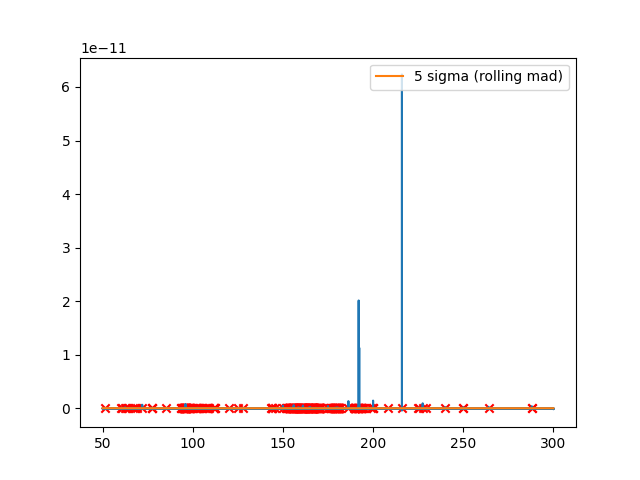

In [105]:
plt.figure()
plt.plot(freqs, diffSpecFiltered)
plt.plot(freqs,diffRollMadLim, label = '5 sigma (rolling mad)')
plt.scatter(freqs[candidate_df['idx']], diffRollMadLim[candidate_df['idx']], color ='r', marker = 'x')
plt.legend(loc = 'upper right')

print('stepsize = %i ' %stepsize)
print('butter filter (order = %i and' %order, 'f_c = %i'  %fc_numBins, 'bins)')

print('number of candidates = ', len(candidate_df['idx']) )

In [ ]:
nCandidatesDiffMad = (diffSpecFiltered > filteredMadArrPad*5*madCor).sum()
print('filtered raw diff data has ', nCandidatesDiffMad, 'candidates (mad)')

plt.close('all')
plt.figure()
plt.plot(freqs, diffSpecFiltered)
plt.plot(freqs, filteredMadArrPad*5*madCor)

In [ ]:
#inspect rolling MAD parameters
plt.close('all')
plt.figure()
plt.plot(freqs, antSpecFiltered)
#plt.plot(rollingMadArr*5*madCor)
plt.plot(freqs, filteredMadArrPad*5*madCor)
#plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 1000, type = 'lowpass'), label = 'filtered rolling mad')
plt.legend(loc = 'upper right')

plt.figure()
plt.plot(filteredMadArrPad*madCor)
plt.plot(stdsInterp , label = "5 * true std (before spurs)")
plt.legend(loc = 'upper right')

plt.figure()
plt.plot((stdsInterp - madCor*filteredMadArrPad))

#plt.plot(rollingMadArr*5*madCor)
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 500, type = 'lowpass'))

#plt.plot(((rollingMadMp*madCor)[1:] - stdsInterp)/stdsInterp)

stdErr = ((stdsInterp - madCor*filteredMadArrPad)/stdsInterp)
stdErrStd = stdErr[np.logical_not(np.isnan(stdErr))].std()
print(stdErrStd)

In [ ]:
#filter, remove center spur. 
# plot with 5sigma limit. Note these are not gain corrected!!!

#set center interleaving spur to it's negbor. See spur hunting sheet for these indicies
antSpecClean = (antSpec)

idxInterleaving = range(4194301-idxStart,4194306-idxStart)
for i in idxInterleaving:
    antSpecClean[i] =  antSpecClean[i+5]

antSpecCleanFilter = dr.filterSpec(antSpecClean)

antMAD = (sp.stats.median_abs_deviation(antSpecCleanFilter))
antLimit = 5 * antMAD
print('limit = ', antLimit, 'Watts')

nCandidates = (antSpecCleanFilter > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')




plt.figure()
plt.plot(freqs, dr.filterSpec(antSpecClean))
plt.plot((freqStart, 300),(antLimit, antLimit))


'''
antLimit = dr.fft2Watts(5 * sp.stats.median_abs_deviation(dr.filterSpec(antDataAll[idxStart:idxStart + 1000])))

nCandidates = (filteredAntSpecWatts > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')

%matplotlib widget
plt.close('all')

plt.figure()
plt.title('Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')


plt.figure()
plt.title('Zoom Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.plot((freqStart, 300),(antLimit, antLimit))
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.ylim(-2e-13, 2e-13)
'''

In [ ]:
#mp spcipy based homebrew 
#print(x)
window = 5000
step = 1
spec = x

strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)

#multiprocess rolling MAD on strided array
def MAD(spec):
    #print(spec)
    #return np.full(step, sp.stats.median_abs_deviation(spec))
    return sp.stats.median_abs_deviation(spec)
with mp.Pool(40) as p:
    rollingMadMp = p.map(MAD, strideSpec[::step])

rollingMadMp = np.asarray(rollingMadMp).reshape(-1)

'''
infArr = np.full(window//2, float('nan'))
rollingMadMp = np.append(infArr, rollingMadMp)
rollingMadMp = np.append(rollingMadMp, infArr)
'''


In [ ]:
window = 3
step = 2
spec = x
strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)
rollingMadMp = np.zeros(len(spec - window))

for i, spec in enumerate(strideSpec[::step]):
    rollingMadMp[i] = sp.stats.median_abs_deviation(spec)


In [ ]:
#rolling std using pd rolling
antSpecFiltered = dr.filterSpec(antSpec)
termSpecFiltered = dr.filterSpec(termSpec)



antFilter_Df = pd.DataFrame(antSpecFiltered)
antRollingStd = antFilter_Df.rolling(10000).std()
termFilter_Df = pd.DataFrame(termSpecFiltered)
termRollingStd = termFilter_Df.rolling(10000).std()
termRollingMad = rollingMadMp

numTermCandidates = (termSpecFiltered > (6*termRollingStd).to_numpy().T[0]).sum()
numAntCandidates = (antSpecFiltered > (6*antRollingStd).to_numpy().T[0]).sum()
print(numTermCandidates, 'candidates on terminator')
print(numAntCandidates, 'candidates on antenna')

plt.figure()
plt.title('antenna')
plt.plot(antSpecFiltered)
plt.plot(antRollingStd*5)

plt.figure()
plt.title('terminator')
plt.plot(termSpecFiltered)
plt.plot(termRollingStd*5)
plt.plot(termRollingMad*5)

plt.figure()
plt.plot(antSpec)
plt.plot(termSpec)



In [ ]:
plt.figure()
plt.plot(rollingMad)
plt.plot(rollingStd * .67)

In [ ]:
#pandas rolling std

df = pd.DataFrame(antSpecCleanFilter)
arr = np.asarray(df.rolling(10000).std())
limit = 6 * arr

plt.figure()
plt.plot(freqs, antSpecCleanFilter)
plt.plot(freqs, limit, label = '5sigma thresh')

'''
count = 0
for i in range(len(antSpecCleanFilter)):
    if antSpecCleanFilter[i]>limit[i]:
        count += 1
print(count)
'''

In [ ]:
df = pd.DataFrame(antSpec)
arr = (df.rolling(100).median())
diff = (df - arr)
std = 5 * diff.rolling(10000).std()

plt.figure()
plt.plot(freqs, antSpec)
plt.plot(freqs,arr)

plt.figure()
plt.plot(freqs, diff)
plt.plot(freqs, std)



In [ ]:
plt.close('all')
plt.figure()
plt.plot(a)

In [ ]:
#show interleaving spur is single bin wide

plt.close('all')
plt.figure()
plt.scatter(freqs*1e6, dr.fft2dBm(antDataAll))
plt.xlabel('Freq (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(1.499990e8, 1.500010e8)
plt.ylim(-82,-58)

In [ ]:
parsedList, configDic = getParsedList('ConfigDR.ini', 'TEST');

avgSpec = dr.avgSpec(parsedList, '../../../../drBiggerBoy/drData/Data/', verbose=True)